<h1 align=center style="line-height:200%;font-family:vazir;color:#0099cc">
<font face="vazir" color="ffffff">
Resnet code

</font>
</h1>

pariya branch

In [53]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from keras_preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Image, display
import sys
import pandas as pd
from keras.layers import Activation, Dense
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras import Sequential
from keras.layers import BatchNormalization

In [54]:
get_ipython().system('pip install efficientnet')

In [4]:
#from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.resnet50 import preprocess_input

base_model = tf.keras.applications.ResNet50(weights="imagenet",
    input_shape=(100, 100, 3),
    include_top=False)

In [55]:
base_model.trainable = False
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 106, 106, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 50, 50, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 50, 50, 64)   256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [56]:
model = Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(12, activation='softmax'))

In [57]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)

train_ds = train_datagen.flow_from_directory(
    r'E:\projectDataset\archive\sl_train',
    class_mode='categorical',
    target_size=(100,100),
    shuffle=True,
    batch_size=32
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_ds_ = test_datagen.flow_from_directory(
    r'E:\projectDataset\archive\sl_test',
    class_mode='categorical',
    target_size=(100,100),
    batch_size=32
)



val_datagen = ImageDataGenerator(rescale=1./255)
val_ds = val_datagen.flow_from_directory(
    r'E:\projectDataset\archive\sl_valid',
    class_mode='categorical',
    target_size=(100,100),
    shuffle=True,
    batch_size=32
)



Found 2907 images belonging to 12 classes.
Found 1166 images belonging to 12 classes.
Found 1420 images belonging to 12 classes.


In [58]:
model.compile(optimizer='adam', loss = "categorical_crossentropy" , metrics =['accuracy'])

In [59]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping2_acc = EarlyStopping(
    min_delta=0.0001,
    patience=5,
    monitor="accuracy",
    restore_best_weights=True,
    mode="auto"
)

early_stopping2_loss = EarlyStopping(
    min_delta=0.0001,
    patience=5,
    monitor="loss",
    restore_best_weights=True,
    mode="auto"
)

history2 = model.fit(
    train_ds,
    batch_size = 32,
    epochs = 5,
    
    validation_data= val_ds,
    callbacks = [early_stopping2_acc, early_stopping2_loss]
    )
    

Epoch 1/5
91/91 [==============================] - 137s 1s/step - loss: 2.8777 - accuracy: 0.1357 - val_loss: 2.7596 - val_accuracy: 0.1169
Epoch 2/5
91/91 [==============================] - 127s 1s/step - loss: 2.3356 - accuracy: 0.1848 - val_loss: 2.2756 - val_accuracy: 0.1197
Epoch 3/5
91/91 [==============================] - 108s 1s/step - loss: 2.1353 - accuracy: 0.2283 - val_loss: 2.1925 - val_accuracy: 0.2493
Epoch 4/5
91/91 [==============================] - 100s 1s/step - loss: 2.0242 - accuracy: 0.2844 - val_loss: 2.1401 - val_accuracy: 0.2197
Epoch 5/5
91/91 [==============================] - 97s 1s/step - loss: 1.9644 - accuracy: 0.2942 - val_loss: 2.1701 - val_accuracy: 0.2669


In [66]:
model.save('../models/5fruit_disease_classifier_resnet.h5')

In [65]:
test_loss, test_accuracy = model.evaluate(test_ds_, steps=len(test_ds_)/32)
print('Accuracy on test dataset:', test_accuracy)

1/1 [==============================] - 2s 5s/step - loss: 2.2232 - accuracy: 0.3125                  
Accuracy on test dataset: 0.3125


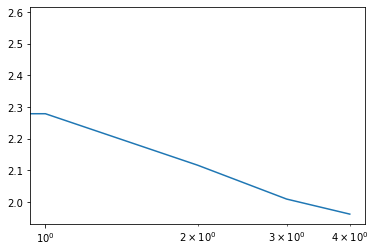

In [67]:
import matplotlib.pyplot as plt

plt.semilogx( history2.history["loss"])

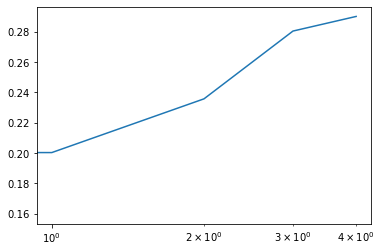

In [68]:
plt.semilogx( history2.history["accuracy"])